In [38]:
pip install torch torchvision opencv-python open3d timm matplotlib pillow

Note: you may need to restart the kernel to use updated packages.


In [45]:
import cv2
import torch
import numpy as np
import open3d as o3d
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.colors as mcolors


In [46]:
img_path = "tree.png"
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_pil = Image.fromarray(img_rgb)

# Convert PIL to NumPy array
img_np = np.array(img_pil)

# Load MiDaS
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid", trust_repo=True)
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms").dpt_transform

# Transform and predict
input_batch = midas_transforms(img_np)
with torch.no_grad():
    prediction = midas(input_batch)
    depth = prediction.squeeze().cpu().numpy()

# Combine with original RGB
depth_resized = cv2.resize(depth, (img_rgb.shape[1], img_rgb.shape[0]))
encoded_matrix = np.dstack((img_rgb, depth_resized))  # (H, W, 4)

Using cache found in /Users/rexouyang/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/rexouyang/.cache/torch/hub/intel-isl_MiDaS_master


In [47]:
#turn this into 3d cloud
H, W, _ = encoded_matrix.shape
flattened = encoded_matrix.reshape(-1, 4)  # shape (H*W, 4)

points_xyz = []
colors_rgb = []

for idx, (r, g, b, d) in enumerate(flattened):
    i = idx // W  # row
    j = idx % W   # column
    x, y, z = j, i, d  # simple mapping

    points_xyz.append([x, y, z])
    colors_rgb.append([r/255.0, g/255.0, b/255.0])


In [48]:
#make clusters
#logic: go through each point and find nearby points in its vicintiy. make triangles. 
#def distance(point1, point2):
#    point1, point2 = np.array(point1), np.array(point2)
#    return math.sqrt(np.sum((point1-point2)**2))

#def connection_poisson_reconstruction()



#Cluster algorithm 1
try:
    import open3d as o3d
except ImportError:
    o3d = None

def poisson_surface_reconstruction(points_xyz, colors_rgb, depth=8, normal_radius=0.1, max_nn=30):
    """
    Poisson Surface Reconstruction using Open3D.

    Args:
        points_xyz (array-like[N, 3]): 3D point coordinates.
        colors_rgb (array-like[N, 3]): RGB colors (0-255 range) for each point.
        depth (int): Depth parameter for the Poisson solver (higher = finer resolution).
        normal_radius (float): Radius for normal estimation.
        max_nn (int): Maximum number of neighbors for normal estimation.

    Returns:
        vertices (np.ndarray[M, 3]): Mesh vertices.
        triangles (np.ndarray[K, 3]): Triangle indices.
        vertex_colors (np.ndarray[M, 3]): Colors for each vertex.
    """
    if o3d is None:
        raise ImportError("Open3D is required for Poisson reconstruction. Install via `pip install open3d`")
    
    # Create point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.asarray(points_xyz))
    colors = np.asarray(colors_rgb) / 255.0  # normalize to [0,1]
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Estimate normals
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=normal_radius, max_nn=max_nn)
    )
    
    # Poisson reconstruction
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=depth)
    
    # Crop the mesh to the bounding box of the original points
    bbox = pcd.get_axis_aligned_bounding_box()
    mesh = mesh.crop(bbox)
    
    # Extract arrays
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    vertex_colors = np.asarray(mesh.vertex_colors)
    
    return vertices, triangles, vertex_colors

def ball_pivoting_reconstruction(points_xyz, colors_rgb, radii=[0.05, 0.1, 0.2], normal_radius=0.1, max_nn=30):
    """
    Ball Pivoting Surface Reconstruction using Open3D.

    Args:
        points_xyz (array-like[N, 3]): 3D point coordinates.
        colors_rgb (array-like[N, 3]): RGB colors (0-255 range) for each point.
        radii (list of float): List of ball radii to try (in increasing order).
        normal_radius (float): Radius for normal estimation.
        max_nn (int): Maximum number of neighbors for normal estimation.

    Returns:
        vertices (np.ndarray[M, 3]): Mesh vertices.
        triangles (np.ndarray[K, 3]): Triangle indices.
        vertex_colors (np.ndarray[M, 3]): Colors for each vertex.
    """
    if o3d is None:
        raise ImportError("Open3D is required for Ball Pivoting reconstruction. Install via `pip install open3d`")
    
    # Create point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.asarray(points_xyz))
    colors = np.asarray(colors_rgb) / 255.0  # normalize to [0,1]
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Estimate normals
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=normal_radius, max_nn=max_nn)
    )
    
    # Ball Pivoting reconstruction
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector(radii)
    )
    
    # Extract arrays
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    vertex_colors = np.asarray(mesh.vertex_colors)
    
    return vertices, triangles, vertex_colors


In [55]:

def plot_mesh(vertices, triangles, vertex_colors=None, title="Mesh"):
    """
    Plot a 3D triangular mesh using Matplotlib with true face coloring.
    
    Args:
        vertices (np.ndarray[M, 3]): Array of vertex coordinates.
        triangles (np.ndarray[K, 3]): Array of triangle indices.
        vertex_colors (np.ndarray[M, 3], optional): RGB colors for each vertex in [0–255].
        title (str): Title of the plot.
    """
    # Early exit on empty mesh
    if len(vertices)==0 or len(triangles)==0:
        print(f"Warning: Empty mesh for '{title}'.")
        return
    
    vertices = np.asarray(vertices)
    triangles = np.asarray(triangles)
    
    # Validate and filter triangles
    valid = np.all(triangles < len(vertices), axis=1)
    triangles = triangles[valid]
    if len(triangles)==0:
        print(f"Warning: No valid triangles for '{title}'.")
        return
    
    # Build list of face vertex coords
    faces = vertices[triangles]
    
    # Determine face RGBA colors
    if vertex_colors is not None:
        vc = np.asarray(vertex_colors, dtype=float)
        # normalize to [0,1]
        if vc.max() > 1.0:
            vc = vc / 255.0
        # average per triangle
        face_rgb = np.mean(vc[triangles], axis=1)
    else:
        # default light gray
        face_rgb = np.tile(np.array([0.8,0.8,0.8]), (len(faces),1))
    
    # Add alpha channel
    face_rgba = np.concatenate([face_rgb, np.ones((face_rgb.shape[0],1))], axis=1)
    
    # Create Poly3DCollection without edges
    poly = Poly3DCollection(faces, facecolors=face_rgba, linewidths=0, edgecolors='none')
    
    # Plot
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.add_collection3d(poly)
    
    # Auto‐scale axes
    mins = vertices.min(axis=0)
    maxs = vertices.max(axis=0)
    ranges = maxs - mins
    pad = 0.1
    ax.set_xlim(mins[0]-pad*ranges[0], maxs[0]+pad*ranges[0])
    ax.set_ylim(mins[1]-pad*ranges[1], maxs[1]+pad*ranges[1])
    ax.set_zlim(mins[2]-pad*ranges[2], maxs[2]+pad*ranges[2])
    
    # Labels & title
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.set_title(f"{title} ({len(vertices)} verts, {len(triangles)} tris)")
    ax.view_init(elev=20, azim=45)
    plt.tight_layout()
    plt.show()



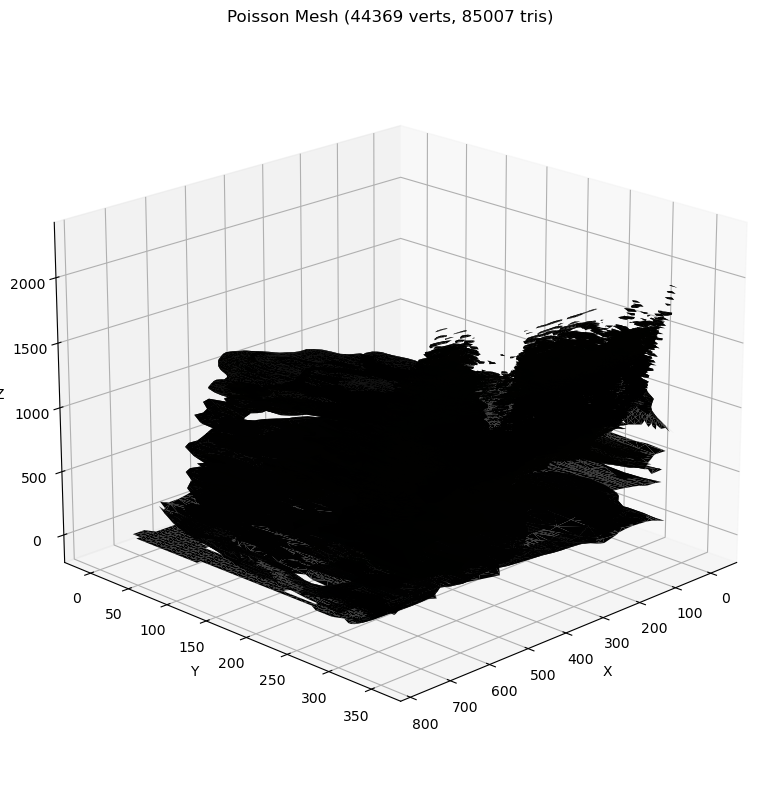

In [56]:
verts, tris, cols = poisson_surface_reconstruction(points_xyz, colors_rgb)
plot_mesh(verts, tris, cols, title="Poisson Mesh")



verts, tris, cols = ball_pivoting_reconstruction(points_xyz, colors_rgb)
plot_mesh(verts, tris, cols, title="Ball Pivoting Mesh")
